In [3]:
pip install scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install pandas


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import joblib
import sys
import os
import pandas as pd
import argparse
import warnings
warnings.filterwarnings("ignore")
import argparse
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import numpy as np


In [15]:

##############################################NEW SECTION OF CODE. - BALANCE THE CODE TO ENSURE ACCURACY  #####################################################

# Load dataset
df = pd.read_csv("/Users/anyakhurana/Documents/Rpo_analysis_project/rpoABC_variation_rifampicin_resistance.csv")

# Target encoding
y = df['Resistance'].map({'S': 0, 'R': 1}).astype(int)

# One-hot encode features
X = df.drop(columns=['ID', 'Resistance'])
X = pd.get_dummies(X, drop_first=False)

# Stratified CV for fairness
cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print("Class balance:", y.value_counts(normalize=True))
print("X shape:", X.shape)
print("y shape:", y.shape)




############################################## SAVE THE MODEL TO NEW PATH ###############################################################################################

## Prepares data for the ML Models
# Define the path to save the model
model_path = "/Users/anyakhurana/Documents/Rpo_analysis_project/rpoABC_variation_rifampicin_resistance_model.pkl"
# Check if the model already exists
if os.path.exists(model_path):
    print("Model already exists. Loading the model...")
    model = joblib.load(model_path)
else:  
    print("Model does not exist. Creating a new model...")
    # Initialize the scaler
    scaler = StandardScaler()
    
    # Create a pipeline with scaling and classifier
    pipeline = Pipeline([
        ('scaler', scaler),
        ('classifier', LogisticRegression(random_state=42))
    ])
    
    # Fit the model
    pipeline.fit(X, y)
    
    # Save the model
    joblib.dump(pipeline, model_path)
    print(f"Model saved to {model_path}")



############################################## # fair and repeatable 10-fold cross-validation that preserves class balance,##############################################################################################

from sklearn.model_selection import StratifiedKFold
cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


############################################## # DEFINE THE LOGISTIC REGRESSION PIPELINE ##############################################################################################


logreg_pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

rf_pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])


##############################################TRAIN AND TEST DATA##############################################################################################

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,     
    random_state=42
)
print("Training set class balance:", y_train.value_counts(normalize=True))
print("Test set class balance:", y_test.value_counts(normalize=True))



############################################## # HYPERTUNE THE MODEL ##############################################################################################

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Assume df is already loaded
X = df.drop(columns=['ID', 'Resistance'])
y = df['Resistance']
X_encoded = pd.get_dummies(X)

# Define parameter grid for Logistic Regression
param_grid = {
    'C': np.logspace(-4, 4, 20),          # regularization strength
    'penalty': ['l1', 'l2', 'elasticnet', 'none'], 
    'solver': ['saga'],                    # saga supports l1, l2, elasticnet
    'max_iter': [500, 1000, 1500]          # number of iterations
}

logreg = LogisticRegression(random_state=42)

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_grid,
    n_iter=20,
    cv=cv_strategy,
    n_jobs=-1,
    random_state=42,
    scoring='accuracy'
)

random_search.fit(X_encoded, y)

print("Best Parameters:", random_search.best_params_)
print("Best Estimator:", random_search.best_estimator_)
print("Best CV Accuracy:", random_search.best_score_)





############################################## # CROSS VALIDATE THE MODEL ##############################################################################################


from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import numpy as np

# Assume random_search is from your Logistic Regression hyperparameter tuning
best_params_logreg = random_search.best_params_

# Create the best Logistic Regression model
logreg_best = LogisticRegression(
    **best_params_logreg,
    random_state=42,
    n_jobs=-1
)

# 10-fold stratified cross-validation
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores_logreg = cross_val_score(logreg_best, X_encoded, y, cv=cv_10)

print("Cross-validation accuracies (Logistic Regression):", scores_logreg)
print("Average accuracy (Logistic Regression):", np.mean(scores_logreg))





Class balance: Resistance
1    0.5
0    0.5
Name: proportion, dtype: float64
X shape: (98, 197)
y shape: (98,)
Model already exists. Loading the model...
Training set class balance: Resistance
0    0.5
1    0.5
Name: proportion, dtype: float64
Test set class balance: Resistance
1    0.5
0    0.5
Name: proportion, dtype: float64
Best Parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1000, 'C': np.float64(78.47599703514607)}
Best Estimator: LogisticRegression(C=np.float64(78.47599703514607), max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
Best CV Accuracy: 0.8678947368421053
Cross-validation accuracies (Logistic Regression): [0.8        0.6        1.         0.7        0.9        0.9
 0.7        1.         0.88888889 1.        ]
Average accuracy (Logistic Regression): 0.8488888888888889


Accuracy (Logistic Regression): 0.95
              precision    recall  f1-score   support

           R       1.00      0.90      0.95        10
           S       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



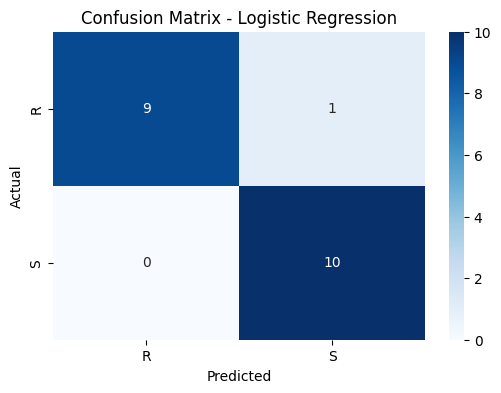

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression Model (with hyperparameters you might have tuned earlier)
log_reg = LogisticRegression(
    solver="liblinear", 
    C=1.0, 
    penalty="l2", 
    random_state=42
)

# Fit model
log_reg.fit(X_train, y_train)

# Predictions
y_pred_log = log_reg.predict(X_test)

# Print Metrics
print("Accuracy (Logistic Regression):", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_log)

# Heatmap of Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()
